# Recommendation Notebook 


## Notes

### 1/12
- Tweaked hyperparameters to get optimal performance (for now)
- Blank descriptions are now replaced with club name respectively
- Clubs that aren't confirmed are not included in dataset

### 1/10
- Create 3rd temporary recommendation system based off of favorites and interest lists. Basically just added case where favorites_list does not exist, so then tags are taken into consideration instead. This version still does not take tags into account when a favorites list does exist, however. We can improve this part if we want in future versions.

### 1/8
- Added .env variable support for use with version control
- Added frequency distribution graph for words from descriptions

### 1/6
- Created 2nd temporary recommendation system based off of favorites, would like to include tags incorporated, even though we use the recommendation function that takes into consideration tags already
- Figure out how to recommend even with no favorites, just tags

### 12/31
- Added various graphs for visualizing performance of model
- Fixed environment by list dependencies without specific versions
- Re-added directly importing data from MongoDB

### 12/30
- Will most likely want to give slack for k when recommending, since we don't want to have the exact same results each time
- (Possibly pick from distributions?)
- favorite_recommendation does not work as well as hoped, need to reevaluate how well it works + other strategies

### 12/28
- Switched from euclidean distance to cosine similarity
- Fixed runtime for vectorizing the table

### 12/23
- Annotation, a lot
- Recommend function takes into consideration tags
- Notebook formatted

### 12/10
- Started
- Issues importing from Tejas's environment, unable to connect to DB so exported directly from MongoDB
- Used nlp/gensim to vectorize description, use K-nn approach to recommend

# Imports

In [1]:
# import packages
# Native imports
import os
import json
import random

# MongoDB Python driver import
import pymongo

# 3rd-party data science imports
import pandas as pd
import seaborn as sns
# pd.set_option('display.max_rows', None)

# NLP Pre-processing tools
import re, string, unicodedata
import nltk
#import contractions      # https://github.com/kootenpv/contractions
#import inflect           # https://github.com/jaraco/inflect
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
#import flashtext         # https://github.com/vi3k6i5/flashtext

# Main NLP tool kit
import gensim           # https://radimrehurek.com/gensim/auto_examples/index.html

# Model training
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier

from sklearn.manifold import TSNE

import bs4 as bs
import nltk
from nltk.tokenize import sent_tokenize # tokenizes sentences
import re
from nltk.stem import PorterStemmer
from nltk.tag import pos_tag
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
import numpy as np

# Extra tooling
import dotenv

In [2]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 12)

In [3]:
# Load .env variables
from dotenv import load_dotenv
load_dotenv()

True

## Step 0: Fetch data

### Directly from MongoDB

In [4]:
conn_string = os.getenv('MONGO_URI_PROD')
client = pymongo.MongoClient(conn_string)

In [5]:
ALL_CLUB_TAGS = []

# Fetch list of tags
for tag in client['production-db']['tag'].find():
    ALL_CLUB_TAGS += [{
        'id': tag['_id'],
        'name': tag['name']
    }]

all_club_tags_df = pd.DataFrame(ALL_CLUB_TAGS)
all_club_tags_df.head(25)

,id,name
0,0,Advocacy
1,1,ASUC
2,2,Business
3,3,CalGreek
4,4,Community Service
5,5,Computer Science
6,6,Consulting
7,7,Cultural
8,8,Design
9,9,Engineering


In [6]:
club_info_db = []

for user in client['production-db']['new_base_user'].find({'role': 'officer', 'confirmed': True}):
    club_name = user['club']['name'].strip()
    club_description = user['club']['about_us'].strip()
    club_tags = user['club']['tags']
    
    club_info_db += [{
        'name': club_name,
        'description': club_description,
        'tags': club_tags,
    }]
    
club_db_df = pd.DataFrame(club_info_db)
club_db_df = club_db_df.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)
club_db_df = club_db_df.reset_index(drop = True)

for (i, row) in club_db_df.iterrows():
    row['description'] = row['description'] if len(row['description']) != 0 else row['name']

club_db_df

,name,description,tags
0,The Berkeley Alt. Protein Project,The Berkeley Alt. Protein Project strives to b...,"[10, 11, 18]"
1,EthiCAL Apparel,EthiCAL Apparel is a student-run social enterp...,"[2, 10, 20]"
2,UC Rally Committee,The UC Rally Committee’s members are the offic...,"[20, 21]"
3,Formula Electric at Berkeley,Join us in building Cal's first ever Formula S...,"[2, 8, 9]"
4,Codebase,Codebase is a community of developers that emp...,"[5, 6, 22]"
...,...,...,...
228,Global Medical Missions Alliance,Global Medical Missions Alliance,"[4, 11, 16]"
229,Taiwanese American Student Association,TASA is a social and cultural student organiza...,"[7, 19]"
230,Alpha Phi Omega,Alpha Phi Omega,"[4, 15, 20]"
231,Kidney Disease Screening and Awareness Program,Join a group of pre-health students and work a...,"[4, 11, 20]"


# Club Recommendation

## Step 1: Clean table descriptions

In [7]:
def clean_table(table):
    """
    Description:
    Cleans club dataframe descriptions into another column containing a lists of significant words in each description.
    
    Input:
    table - club dataframe
    
    Output:
    cleaned_table - table with a new column: "cleaned descriptions"
    
    """
    
    def clean_description(description):
        """
        Description:
        Clean single description into lists of significant words.

        Input:
        description - string of club description 

        Output:
        new_description - list of significant words in description
        """
        
        try: 
            # Remove punctuation
            new_description = re.sub("[^a-zA-Z]", " ", description)

            # Tokenize into words (all lower case)
            new_description = new_description.lower().split()

            # Remove stopwords
            eng_stopwords = set(stopwords.words("english"))
            new_description = [w for w in new_description if not w in eng_stopwords]

            # Remove "uc" and "berkeley"
            uc_berkeley = ['uc', 'berkeley', 'also', 'providing', 'various', 'well', 'provide', 'one']
            new_description = [w for w in new_description if not w in uc_berkeley]
        except TypeError:
            return [""]

        return new_description
    
    clean_descriptions = []
    
    for i in np.arange(len(table)):
        clean_descriptions += [clean_description(table['description'][i])]
        
    cleaned_table = table.drop(['description'], axis=1)
    cleaned_table['clean_description'] = clean_descriptions
    
    return cleaned_table

## Step 2: Add vectors

In [8]:
def vectorize_table(table, yield_model = False):
    MIN_WORD_COUNT = 20
    VECTOR_SIZE = 100
    CONTEXT_WINDOW_SIZE = 10
    
    """
    Description:
    Uses cleaned table to create another column containing vectors using gensim's word2vec.
    
    Input:
    table - cleaned table
    
    Output:
    vectorized_table - table with a new_column: "vector sum"
    
    Run word2vec model
    """
    
    list_vectors = []
    
    model = gensim.models.Word2Vec(
        table['clean_description'],
        min_count=MIN_WORD_COUNT,
        size=VECTOR_SIZE,
        window=CONTEXT_WINDOW_SIZE,
        compute_loss=True,
        sample=1e-3 / 2,
    )
    
    for i in range(len(table)):
        ith_description = table['clean_description'][i]    
        
        ith_vector_list = []
        for ith_description_word in ith_description:
            if ith_description_word in model:
                ith_vector_list += [model[ith_description_word]]
        
        if len(ith_vector_list) == 0:
            description_sum_vector = [1e-6] * VECTOR_SIZE
        else:
            description_sum_vector = sum(np.array(ith_vector_list))
            
        list_vectors += [description_sum_vector]
        
    vectorized_table = table.copy()
    vectorized_table['vector_sum'] = list_vectors
    
    if yield_model:
        return vectorized_table, model
    else:
        return vectorized_table

## Step 3: Create distance table

In [9]:
from scipy import spatial

def create_distance_table(table):
    """
    Description:
    Uses a vectorized table to create a pivot table containing distances between each club.
    
    Input:
    table - table with vectorized descriptions
    
    Output:
    distance_table - table containing all distances between each club
    
    """
    
    dict = table[['name','vector_sum']].set_index('name')['vector_sum'].to_dict()
    distance_list = []
    
    for club_1 in dict:
        vector_1 = dict[club_1]
        distance_dictionary = {}
        
        for club_2 in dict:
            vector_2 = dict[club_2]
            
            cosine_sim = 1 - spatial.distance.cosine(vector_1, vector_2)
            distance_dictionary[club_2] = cosine_sim
            
        distance_list += [distance_dictionary]
        
    distance_table = pd.DataFrame(data=distance_list)
    distance_table.index = table['name']
    
    return distance_table

## Step 4: Recommend

In [10]:
def recommend(table, club_db_df, club_name, k):
    """
    Description:
    Recommends club based off of k-nearest neighbors, prioritizing matching tags.
    
    Input:
    table - table containing all distances between each club
    club_db_df - table containing club tags
    club_name - string of club name we want to create recommendations for
    k - represents how many neighbors
    
    Output:
    recommendations - k recommendations based off of closest distances
    
    """
    
    def filter_by_tag(club_name, k):
        """
        Description:
        Return boolean list that contains max amount of matching tags that satisfies matching k amount of clubs.

        Output:
        filtered_clubs - list of booleans based off of clubs filtered by tags

        """
        
        def count_tags(a, b, num_tags):
            """
            Description:
            Returns if club A and B contain at least k tags in common.

            Input:
            a - list of club tags for club A
            b - list of club tags for club B
            num_tags - minimum number of tags required to match

            Output:
            matching_tags - # of matching tags

            """
            matching_tags = len(set(a).intersection(set(b))) >= num_tags
            return matching_tags

        club_tags = club_db_df[club_db_df['name'] == club_name]['tags'].iloc[0]
        filtered_clubs = []

        num_of_tags = len(club_tags)
        while (np.count_nonzero(filtered_clubs) - 1 < k):
            if num_of_tags == 0:
                print("Matched {} tags".format(num_of_tags))
                return [True] * len(club_db_df)

            filtered_clubs = []
            for other_club_tags in club_db_df['tags']:
                if count_tags(club_tags, other_club_tags, num_of_tags):
                    filtered_clubs += [True]
                else:
                    filtered_clubs += [False]
            num_of_tags -= 1

        else:
            #print("Matched {} tags".format(num_of_tags + 1))
            #print("{} matches".format(np.count_nonzero(filtered_clubs)))
            return filtered_clubs
    
    filtered_clubs = filter_by_tag(club_name, k)
        
    filtered_distances = table[filtered_clubs]
    club_distances = filtered_distances[club_name] 
    sorted_club_distances = club_distances.sort_values(ascending = True, na_position = 'last')
    recommendations = sorted_club_distances.keys()[1: k + 1]
    
    return list(recommendations)

# Example

In [11]:
cleaned_table = clean_table(club_db_df)
cleaned_table

,name,tags,clean_description
0,The Berkeley Alt. Protein Project,"[10, 11, 18]","[alt, protein, project, strives, build, health..."
1,EthiCAL Apparel,"[2, 10, 20]","[ethical, apparel, student, run, social, enter..."
2,UC Rally Committee,"[20, 21]","[rally, committee, members, official, guardian..."
3,Formula Electric at Berkeley,"[2, 8, 9]","[join, us, building, cal, first, ever, formula..."
4,Codebase,"[5, 6, 22]","[codebase, community, developers, empowers, st..."
...,...,...,...
228,Global Medical Missions Alliance,"[4, 11, 16]","[global, medical, missions, alliance]"
229,Taiwanese American Student Association,"[7, 19]","[tasa, social, cultural, student, organization..."
230,Alpha Phi Omega,"[4, 15, 20]","[alpha, phi, omega]"
231,Kidney Disease Screening and Awareness Program,"[4, 11, 20]","[join, group, pre, health, students, work, alo..."


In [12]:
BOWs = cleaned_table['clean_description'].tolist()
total_BOW = [word for bow in BOWs for word in bow]

In [13]:
print('Total # of words: ', len(total_BOW))
print('Total # of unique words: ', len(set(total_BOW)))

Total # of words:  9939
Total # of unique words:  2895


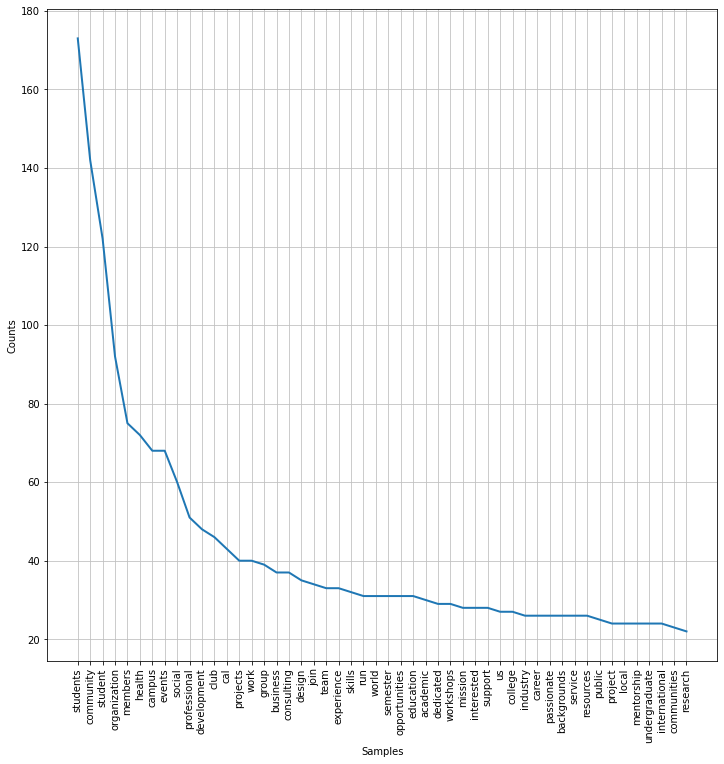

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [14]:
nltk.FreqDist(total_BOW).plot(50, cumulative=False)

In [15]:
vector_table, w2v_model = vectorize_table(cleaned_table, yield_model=True)
print('Model Loss:', w2v_model.get_latest_training_loss())
vector_table

Model Loss: 11058.6181640625


/home/tejashah88/extra-software/anaconda3/envs/sc-notebook/lib/python3.6/site-packages/ipykernel_launcher.py:35: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/tejashah88/extra-software/anaconda3/envs/sc-notebook/lib/python3.6/site-packages/ipykernel_launcher.py:36: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


,name,tags,clean_description,vector_sum
0,The Berkeley Alt. Protein Project,"[10, 11, 18]","[alt, protein, project, strives, build, health...","[-0.012035832, -0.007995122, 0.0024132596, -0...."
1,EthiCAL Apparel,"[2, 10, 20]","[ethical, apparel, student, run, social, enter...","[-0.012423705, -0.013600759, -0.010566732, -0...."
2,UC Rally Committee,"[20, 21]","[rally, committee, members, official, guardian...","[0.005734687, -0.052089654, 0.007503976, -0.03..."
3,Formula Electric at Berkeley,"[2, 8, 9]","[join, us, building, cal, first, ever, formula...","[-0.0021174971, -0.011672628, 0.006345698, -0...."
4,Codebase,"[5, 6, 22]","[codebase, community, developers, empowers, st...","[-0.009859257, -0.038907435, 0.00966513, -0.02..."
...,...,...,...,...
228,Global Medical Missions Alliance,"[4, 11, 16]","[global, medical, missions, alliance]","[1e-06, 1e-06, 1e-06, 1e-06, 1e-06, 1e-06, 1e-..."
229,Taiwanese American Student Association,"[7, 19]","[tasa, social, cultural, student, organization...","[-0.0062823864, -0.0031620255, -0.0055657476, ..."
230,Alpha Phi Omega,"[4, 15, 20]","[alpha, phi, omega]","[1e-06, 1e-06, 1e-06, 1e-06, 1e-06, 1e-06, 1e-..."
231,Kidney Disease Screening and Awareness Program,"[4, 11, 20]","[join, group, pre, health, students, work, alo...","[0.0024509397, -0.020346068, 0.005254563, -0.0..."


/home/tejashah88/extra-software/anaconda3/envs/sc-notebook/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


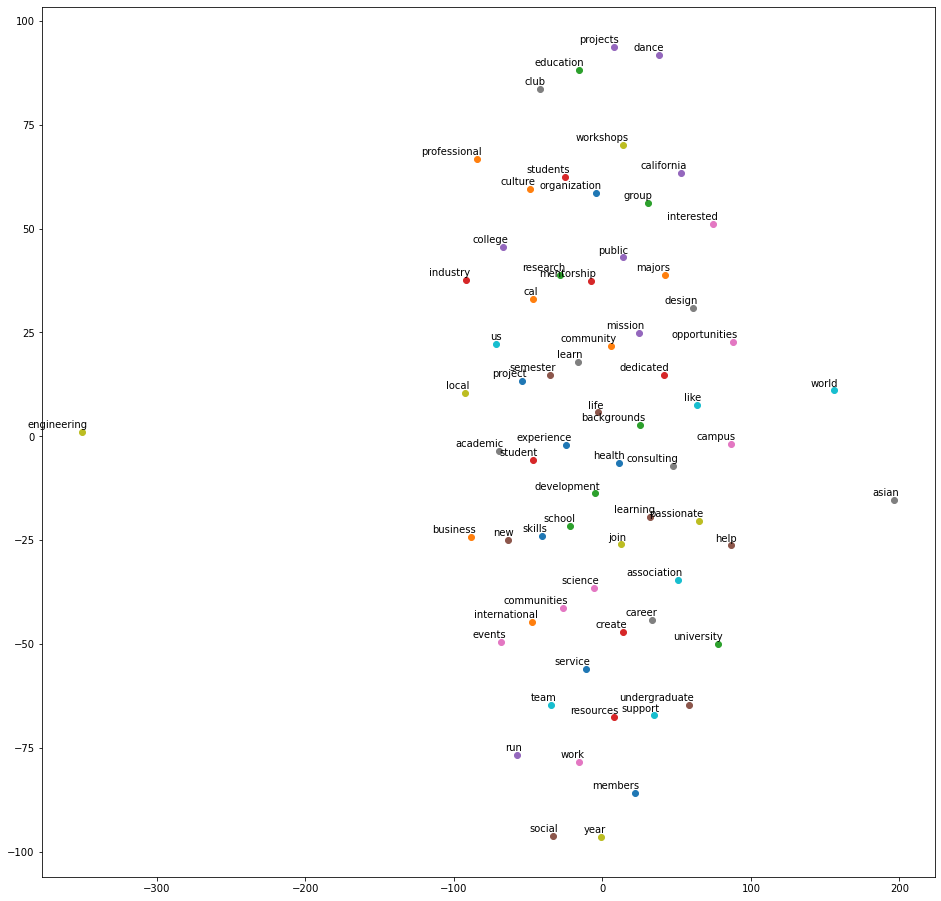

In [16]:
# Source: https://www.kaggle.com/jeffd23/visualizing-word-vectors-with-t-sne

def tsne_plot(model):
    "Creates a TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
        
    tsne_model = TSNE(perplexity=60, n_components=2, init='pca', n_iter=1000, random_state=42)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()
    
tsne_plot(w2v_model)

In [17]:
distance_table = create_distance_table(vector_table)
distance_table

,The Berkeley Alt. Protein Project,EthiCAL Apparel,UC Rally Committee,Formula Electric at Berkeley,Codebase,Berkeley Phi Beta Lambda,Cal Seismic Design Team,SENDforC at UC Berkeley,BEAM- Berkeley Engineers and Mentors,Berkeley Finance Club,...,Berkeley Chinese Students And Scholars Association,Chinese People Union,Achievement in Mentorship (AIM),Codeology,Blue & Gold Yearbook,Global Medical Missions Alliance,Taiwanese American Student Association,Alpha Phi Omega,Kidney Disease Screening and Awareness Program,Project SMILE
name,,,,,,,,,,,,,,,,,,,,,
The Berkeley Alt. Protein Project,1.000000,0.440060,0.473533,0.372975,0.507397,0.526226,0.430333,0.575302,-0.089000,0.524105,...,0.475791,-0.089000,0.517770,0.605724,-0.089000,-0.089000,0.476124,-0.089000,0.492978,0.605739
EthiCAL Apparel,0.440060,1.000000,0.616450,0.530290,0.677102,0.688132,0.722844,0.668589,0.122263,0.616252,...,0.729840,0.122263,0.628476,0.722605,0.122263,0.122263,0.726744,0.122263,0.574044,0.627480
UC Rally Committee,0.473533,0.616450,1.000000,0.463527,0.657697,0.710321,0.599813,0.543070,0.122846,0.614841,...,0.837011,0.122846,0.623084,0.726563,0.122846,0.122846,0.605741,0.122846,0.607793,0.573758
Formula Electric at Berkeley,0.372975,0.530290,0.463527,1.000000,0.577011,0.735095,0.510476,0.506796,0.166280,0.592389,...,0.548076,0.166280,0.598374,0.581445,0.166280,0.166280,0.504431,0.166280,0.644253,0.511728
Codebase,0.507397,0.677102,0.657697,0.577011,1.000000,0.828667,0.826012,0.714131,0.231192,0.719036,...,0.791309,0.231192,0.770109,0.814802,0.231192,0.231192,0.701128,0.231192,0.767346,0.724862
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Global Medical Missions Alliance,-0.089000,0.122263,0.122846,0.166280,0.231192,0.190569,0.249109,0.105140,1.000000,0.189326,...,0.207668,1.000000,0.180311,0.114827,1.000000,1.000000,0.105540,1.000000,0.211946,0.090776
Taiwanese American Student Association,0.476124,0.726744,0.605741,0.504431,0.701128,0.732417,0.660378,0.667900,0.105540,0.705063,...,0.673365,0.105540,0.697333,0.753555,0.105540,0.105540,1.000000,0.105540,0.598552,0.643797
Alpha Phi Omega,-0.089000,0.122263,0.122846,0.166280,0.231192,0.190569,0.249109,0.105140,1.000000,0.189326,...,0.207668,1.000000,0.180311,0.114827,1.000000,1.000000,0.105540,1.000000,0.211946,0.090776


<AxesSubplot:ylabel='name'>

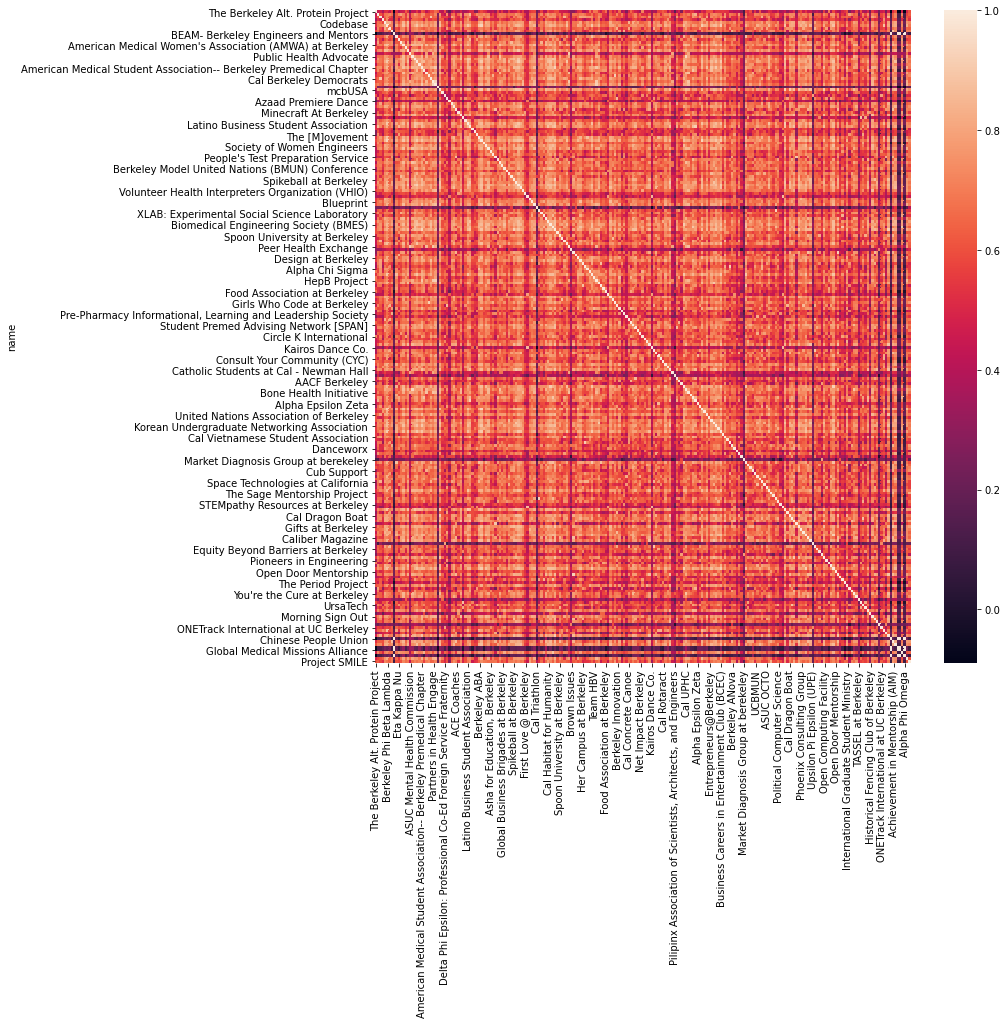

In [18]:
sns.heatmap(distance_table)

/home/tejashah88/extra-software/anaconda3/envs/sc-notebook/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

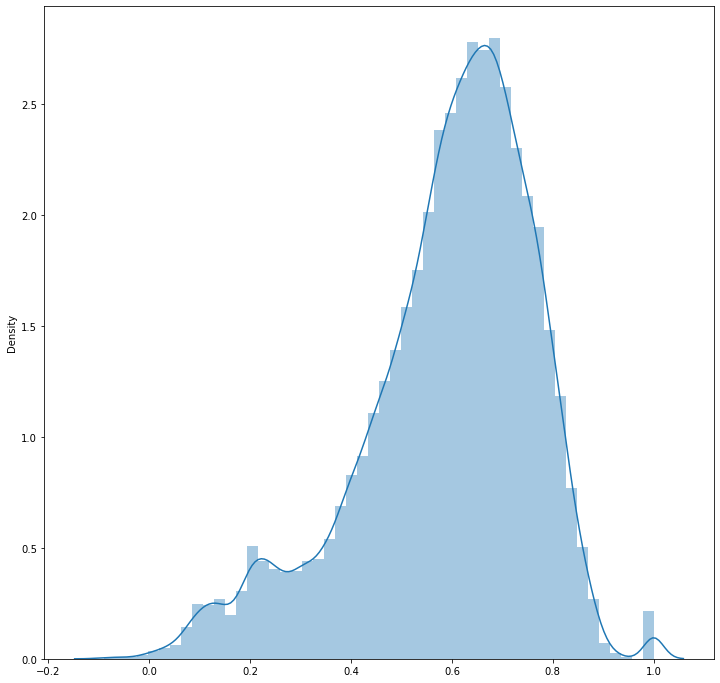

In [19]:
sns.distplot(distance_table)

In [20]:
recommendations = recommend(distance_table, club_db_df, 'sproul.club', 3)
recommendations

['Entrepreneurs@Berkeley', 'Ascend', 'Convergent at Berkeley']

In [21]:
def get_description(club_name):
    return club_db_df[club_db_df['name'] == club_name]['description'].iloc[0]

In [22]:
get_description('Extended Reality at Berkeley')

'Extended Reality @ Berkeley is a registered student organization at Cal for people interested in experiencing or developing virtual and augmented reality technology and applications.'

In [23]:
def recommend_by_club(club_index = -1):
    if club_index == -1:
        club_index = random.randint(0, len(club_db_df))
    print("Club index: {}".format(club_index))
    club_name = club_db_df.iloc[club_index]['name']
    recommended = recommend(distance_table, club_db_df, club_name, 3)
    return club_name, recommended

In [24]:
recommend_by_club(46)

Club index: 46


('Hispanic Engineers and Scientists',
 ['STAR (Space Technologies And Rocketry)', 'Phi Sigma Rho', 'Cal Enviro'])

In [25]:
recommend_by_club()

Club index: 186


('Game Design and Development @ Berkeley',
 ['Girls Teaching Girls to Code @ Berkeley',
  'Eta Kappa Nu',
  'Minecraft At Berkeley'])

## Visualizing/Evaluating Performance

In [26]:
normed_df = vector_table['vector_sum'].apply(lambda arr: arr / np.linalg.norm(arr))
normed_vector_table = np.array([arr for arr in normed_df.to_numpy()])

In [27]:
means = np.mean(normed_vector_table.T, axis=1)
stds = np.std(normed_vector_table.T, axis=1)

print('Mean:', means)
print('Standard Dev:', stds)

print('\n\n')

print('Lowest mean:', np.min(means))
print('Highest mean:', np.max(means))

print('Lowest Standard Dev:', np.min(stds))
print('Highest Standard Dev:', np.max(stds))

Mean: [-1.62611666e-02 -1.12846020e-01  1.31573397e-02 -1.03864595e-01
  4.36065491e-03 -6.97276695e-02  5.83424696e-02 -1.51385653e-01
  5.59924093e-03 -2.58261421e-04 -1.61808431e-02 -5.29303594e-02
  9.35243768e-02 -1.12160253e-01  7.10787418e-02  3.17294968e-02
 -4.39356471e-02  1.86476577e-01  7.07195329e-03 -1.04609221e-01
  1.18639932e-01  1.35878898e-01  4.21656182e-02  8.69089918e-02
 -7.70676336e-02  7.93449765e-02  1.37770579e-03  2.37210038e-02
  8.69244879e-02  6.56619312e-03  2.73832161e-02 -1.84663355e-01
 -1.55877143e-02  9.61739523e-02 -3.87494712e-03 -1.70131756e-03
 -1.28867185e-01  5.05095065e-02 -4.71215531e-02  1.85365612e-02
  7.63834755e-02  4.47846651e-02  3.15045959e-02 -5.97580788e-02
  1.42996844e-04 -6.19277083e-02 -1.66001766e-01  1.00427973e-01
 -3.98840660e-02 -3.19329581e-03  6.57767986e-02  5.47872925e-03
  8.88507804e-02  4.48128457e-02 -1.30065417e-02  1.17528538e-01
  1.16025295e-01  8.10430190e-02 -2.74201797e-02 -7.92892155e-02
  8.78009309e-02 -1

In [ ]:
dims = normed_vector_table.shape[1]

fig, axs = plt.subplots(nrows=dims)

for i in range(dims):
    sns.distplot(normed_vector_table.T[i], bins=100, ax=axs[i])

## Student Profile Recommendation

In [28]:
# DEFUNCT
# DEFUNCT
# DEFUNCT

def favorite_recommendation(favorite_list, k):
    """
    Description:
    Returns k amount of recommendations based off of favorite_list specific to user.

    Input:
    favorite_list - array that contains names of clubs favorited
    k - integer amount of recommendations

    Output:
    recommendations - array of club names recommended

    """
    vector_1 = np.mean(vector_table[vector_table['name'].isin(favorite_list)]['vector_sum'])
    distances = []
    
    for vector_2 in vector_table['vector_sum']:
        cosine_sim = 1 - spatial.distance.cosine(vector_1, vector_2)
        distances += [cosine_sim]
    
    profile_distance = club_db_df.assign(distances = distances) 
    filtered_profile_distance = profile_distance[~profile_distance['name'].isin(favorite_list)]
    sorted_profile_distances = filtered_profile_distance.sort_values(by = 'distances', ascending = True)
    recommendations = list(sorted_profile_distances['name'].iloc[0: k])
    return recommendations
        

Edit favorite_list to see what it will recommend

In [29]:
favorite_list1 = [
    'PlexTech', 
    'Codebase', 
    'Fintech at Berkeley', 
    'Pilipinx Association of Scientists, Architects, and Engineers'
    ]

favorite_recommendation(favorite_list1, 6)

["Active for Alzheimer's",
 'Alpha Phi Omega',
 'Global Medical Missions Alliance',
 'Blue & Gold Yearbook',
 'Chinese People Union',
 'BEAM- Berkeley Engineers and Mentors']

In [30]:
favorite_list2 = [
    'Berkeley Legends', 
    'Cal Animage Alpha'
    ]

favorite_recommendation(favorite_list2, 6)

['Alpha Phi Omega',
 'Global Medical Missions Alliance',
 'Blue & Gold Yearbook',
 'Chinese People Union',
 'BEAM- Berkeley Engineers and Mentors',
 'Creative Arts to Reinspire and Empower (C.A.R.E.)']

In [31]:
favorite_list2 = [
    'Berkeley Legends', 
    'Cal Animage Alpha'
    ]


favorite_recommendation(favorite_list2, 6)

['Alpha Phi Omega',
 'Global Medical Missions Alliance',
 'Blue & Gold Yearbook',
 'Chinese People Union',
 'BEAM- Berkeley Engineers and Mentors',
 'Creative Arts to Reinspire and Empower (C.A.R.E.)']

In [32]:
favorite_list3 = [
    'Consult Your Community (CYC)',
    'Venture Strategy Solutions',
    'Abba Modern',
    'TASSEL at Berkeley',
    'Klesis Christian Fellowship',
    'Entrepreneurs@Berkeley'
                ]


favorite_recommendation(favorite_list3, 6)

['Alpha Phi Omega',
 'Global Medical Missions Alliance',
 'Blue & Gold Yearbook',
 'Chinese People Union',
 'BEAM- Berkeley Engineers and Mentors',
 'Cal Triathlon']

In [33]:
# DEFUNCT
# DEFUNCT
# DEFUNCT

def favorite_recommendation2(favorite_list, k):
    """
    Description:
    Returns k amount of recommendations based off of favorite_list specific to user.

    Input:
    favorite_list - array that contains names of clubs favorited
    k - integer amount of recommendations

    Output:
    recommendations - array of club names recommended

    """
    club_list_pool = []
    for club in favorite_list:
        club_list = recommend(distance_table, club_db_df, club, 6)
        for recommended_club in club_list:
            club_list_pool += [recommended_club]
            
            
    not_in_favorite = [club for club in club_list_pool if club not in favorite_list]
    
    unique_recommended = list(dict.fromkeys(not_in_favorite))
    
    sample_len = len(unique_recommended)
    recommended_indices = random.sample(range(1, sample_len), k)
    recommended = [not_in_favorite[recommended_index] for recommended_index in recommended_indices]
    
    print(recommended)
    print(len(recommended))
    final_recommendation = recommended[:k]
    
    return final_recommendation
        

In [34]:
favorite_recommendation2(['Computer Science Mentors (CSM)', 'Minecraft At Berkeley', 'Cal Hacks'], 6)

['ASUC OCTO', 'MDB', 'Girls Teaching Girls to Code @ Berkeley', 'Extended Reality at Berkeley', 'Girls Teaching Girls to Code @ Berkeley', 'Berkeley Formula Racing']
6


['ASUC OCTO',
 'MDB',
 'Girls Teaching Girls to Code @ Berkeley',
 'Extended Reality at Berkeley',
 'Girls Teaching Girls to Code @ Berkeley',
 'Berkeley Formula Racing']

In [35]:
favorite_recommendation2(['Computer Science Mentors (CSM)', 'Minecraft At Berkeley', 'Cal Hacks'], 6)


['Girls Teaching Girls to Code @ Berkeley', 'Berkeley Formula Racing', 'MDB', 'Extended Reality at Berkeley', 'UrsaTech', 'GroTech @ Berkeley']
6


['Girls Teaching Girls to Code @ Berkeley',
 'Berkeley Formula Racing',
 'MDB',
 'Extended Reality at Berkeley',
 'UrsaTech',
 'GroTech @ Berkeley']

In [36]:
def favorite_recommendation3(favorite_list, interest_list, k):
    """
    Description:
    Returns k amount of recommendations based off of favorite_list and interest_list specific to user.

    Input:
    favorite_list - array that contains names of clubs favorited
    interest_list - array that contains tags (aka interests) student has chosen
    k - integer amount of recommendations

    Output:
    recommendations - array of club names recommended

    """
    #condition that favorite list doesn't exist -- use interest list
    if len(favorite_list) ==0:
        new_club_df = club_db_df[['name', 'tags']]
        intersections = [set.intersection(set(interest_list), set(i)) for i in new_club_df['tags']]
        new_club_df['intersection_with_interests'] = [list(i) for i in intersections]
        new_club_df['num_intersection'] = [len(i) for i in new_club_df['intersection_with_interests']]
        new_club_df = new_club_df.sort_values('num_intersection', ascending = False)
        final_recommendation = list(new_club_df['name'][:k])
    #everything below this point is favorite_recommendation2 above    
    else:
        club_list_pool = []
        for club in favorite_list:
            club_list = recommend(distance_table, club_db_df, club, 6)
            for recommended_club in club_list:
                club_list_pool += [recommended_club]
    
        not_in_favorite = [club for club in club_list_pool if club not in favorite_list]

        unique_recommended = list(dict.fromkeys(not_in_favorite))
        sample_len = len(unique_recommended)
        recommended_indices = random.sample(range(1, sample_len), k)
        recommended = [not_in_favorite[recommended_index] for recommended_index in recommended_indices]

        #print(recommended)
        #print(len(recommended))
        final_recommendation = recommended[:k]

    return final_recommendation
        
    
favorite_recommendation3([], [2,4,6], 5)

['Market Diagnosis Group at berekeley',
 'imagiCal - American Advertising Federation',
 'Seed Base Consulting',
 'Pinnacle Consulting',
 'Voyager Consulting']

In [38]:
recommend(distance_table, club_db_df, 'Global Business Brigades at Berkeley', 3)

['Net Impact Berkeley',
 'Consult Your Community (CYC)',
 'Microfinance at Berkeley']

## Exporting "Generic" Model

In [44]:
LIST_OF_TAGS = []

for officer in client['production-db']['new_base_user'].find({'role': 'officer'}):
    LIST_OF_TAGS += [officer['club']['tags']]

In [41]:
class GenericRecommender:
    def __init__(self, table):
        self.dist_table = table
        
    def _count_tags(self, a, b, num_tags):
        """
        Description:
        Returns if club A and B contain at least k tags in common.

        Input:
        a - list of club tags for club A
        b - list of club tags for club B
        num_tags - minimum number of tags required to match

        Output:
        matching_tags - # of matching tags

        """
        matching_tags = len(set(a).intersection(set(b))) >= num_tags
        return matching_tags
    
    
    def _filter_by_tag(self, club_tags, k):
        """
        Description:
        Return boolean list that contains max amount of matching tags that satisfies matching k amount of clubs.

        Output:
        filtered_clubs - list of booleans based off of clubs filtered by tags

        """

        filtered_clubs = []

        num_of_tags = len(club_tags)
        while (np.count_nonzero(filtered_clubs) - 1 < k):
            if num_of_tags == 0:
                print(f'Matched {num_of_tags} tags')
                return [True] * len(club_db_df)

            filtered_clubs = []
            for other_club_tags in club_db_df['tags']:
                if self._count_tags(club_tags, other_club_tags, num_of_tags):
                    filtered_clubs += [True]
                else:
                    filtered_clubs += [False]
            num_of_tags -= 1

        else:
            #print("Matched {} tags".format(num_of_tags + 1))
            #print("{} matches".format(np.count_nonzero(filtered_clubs)))
            return filtered_clubs
        
    def recommend(club_link_name, k):
        """
        Description:
        Recommends club based off of k-nearest neighbors, prioritizing matching tags.

        Input:
        table - table containing all distances between each club
        club_db_df - table containing club tags
        club_name - string of club name we want to create recommendations for
        k - represents how many neighbors

        Output:
        recommendations - k recommendations based off of closest distances

        """
        # First, fetch required data
        target_user = NewOfficerUser.objects \
            .filter(club__link_name='karasuno-high-volleyball') \
            .first()
        
        target_club_name = target_user.club.name
        target_club_tags = target_user.club.tags
        
        list_of_officers = NewOfficerUser.objects \
            .only('club.tags')
        
        list_of_tags = [user.club.tags for user in list_of_officers]
        
        # Next, filter by tags
        filtered_clubs = self._filter_by_tag(target_club_tags, k)
        
        # Finally, sort by distances as pre-calculated from Word2Vec
        filtered_distances = self.dist_table[filtered_clubs]
        club_distances = filtered_distances[target_club_name]
        sorted_club_distances = club_distances.sort_values(ascending = True, na_position = 'last')
        recommendations = sorted_club_distances.keys()[1: k + 1]

        return list(recommendations)
        